In [11]:
## Front end stuff
%matplotlib inline
%config InlineBackend.figure_format='retina'

#import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import time
#import cmocean as cm
import xarray as xr
#from dask.distributed import Client
#from xhistogram.xarray import histogram
# Basic constants
rho0 = 1024 #kg/m3
day2sec = 24*60*60

In [12]:
## Load data
cc = xr.open_mfdataset('/g/data/p73/archive/CMIP6/ACCESS-CM2/bi889/history/ocn/ocean_month.nc-1440*')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [13]:
## Function to extract UA, VA, T, S and Volume
def PSI_TS_setup(cc,VAR1,VAR2,i):
    ua = cc.tx_trans[i,:,:,:].values/(1e6*rho0)
    ua[np.isnan(ua)]=0
    va = cc.ty_trans.values[i,:,:,:]/(1e6*rho0)
    va[np.isnan(va)]=0

    if 'tx_trans_gm' in list(cc.keys()):
        GM = True
        ua_gm = cc.tx_trans_gm[i,:,:,:].values/(1e6*rho0)
        ua_gm[np.isnan(ua_gm)]=0
        ua_gm[1:,:,:] = -ua_gm[:-1,:,:]+ua_gm[1:,:,:]
        ua = ua+ua_gm
        va_gm = cc.ty_trans_gm[i,:,:,:].values/(1e6*rho0)
        va_gm[np.isnan(va_gm)]=0
        va_gm[1:,:,:] = -va_gm[:-1,:,:]+va_gm[1:,:,:]
        va = va+va_gm
    else:
        GM = False
    
    t = cc[VAR1][i,:,:,:].values
    s = cc[VAR2][i,:,:,:].values
    t[:,0,:]=t[:,-1,::-1]
    s[:,0,:]=s[:,-1,::-1]
    
    Volume = (cc.dht*cc.area_t/(cc.time.dt.days_in_month*day2sec*1e6))[i,:,:,:].values
    Volume[np.isnan(Volume)]=0
    Volume[:,0,:]=Volume[:,-1,::-1]
    
    return ua,va,t,s,Volume

In [14]:
## Function to Compute streamfunction
def PSI_2VAR(ua,va,t,t2,s,s2,Vol,Tbds,Sbds):
    Udiv = 0*ua
    
    Udiv[:,:,1:] = ua[:,:,1:] - ua[:,:,0:-1];
    Udiv[:,:,0] = ua[:,:,0]-ua[:,:,-1];
    Vdiv = 0*ua
    Vdiv[:,1:,:] = va[:,1:,:] - va[:,0:-1,:];
    Vdiv[:,0,:] = va[:,0,:]-va[:,-1,:];
    Wblah = np.cumsum((Udiv+Vdiv)[::-1,:,:],axis=0)[::-1,:,:]
    W=0*ua
    W[0:-1,:,:]=Wblah[1:,:,:]
    
    u2t = 0*t
    u2t[:,:,:-1]=t[:,:,1:]
    u2t[:,:,-1]=t[:,:,0]

    u2s = 0*s
    u2s[:,:,:-1]=s[:,:,1:]
    u2s[:,:,-1]=s[:,:,0]

    v2t = 0*t
    v2t[:,:-1,:]=t[:,1:,:]
    v2t[:,-1,:]=t[:,0,:]

    v2s = 0*s
    v2s[:,:-1,:]=s[:,1:,:]
    v2s[:,-1,:]=s[:,0,:]

    w2t = 0*t
    w2t[:-1,:,:]=t[1:,:,:]
    w2t[-1,:,:]=t[0,:,:]

    w2s = 0*s
    w2s[:-1,:,:]=s[1:,:,:]
    w2s[-1,:,:]=s[0,:,:]
    
    face_flux = np.hstack((ua.flatten(),va.flatten(),W.flatten(),Vol.flatten()))
    tup = np.hstack((t.flatten(),t.flatten(),t.flatten(),t.flatten()))
    sup = np.hstack((s.flatten(),s.flatten(),s.flatten(),s.flatten()))
    tdn = np.hstack((u2t.flatten(),v2t.flatten(),w2t.flatten(),t2.flatten()))
    sdn = np.hstack((u2s.flatten(),v2s.flatten(),w2s.flatten(),s2.flatten()))
    
    PSI_TS = np.zeros((len(Tbds),len(Sbds)))
    
    for i in range(0,len(Tbds)):
         xup = np.where((tup>Tbds[i]) & (tdn<Tbds[i]))
         xdn = np.where((tup<Tbds[i]) & (tdn>Tbds[i]))
         Ucross = np.concatenate((face_flux[xup],-face_flux[xdn]))
         Scross = np.concatenate((\
             sup[xup]+(Tbds[i]-tup[xup])*(sdn[xup]-sup[xup])/(tdn[xup]-tup[xup]),\
             sup[xdn]+(Tbds[i]-tup[xdn])*(sdn[xdn]-sup[xdn])/(tdn[xdn]-tup[xdn]))) 
         PSI_TS[i,1:] = np.cumsum(np.histogram(Scross,Sbds,weights=Ucross)[0])
    
    return PSI_TS


In [15]:
## Bit that actually does it (you can use any 2 variables!)
#VAR1 = 'neutral_rho'
VAR1 = 'salt'
#VAR2 = 'press'
VAR2 = 'temp'
#V1bds = np.arange(10,50,0.2)+1000
#V2bds = np.arange(0,6000,200)
V1bds = np.arange(32,37.5,0.1)
V2bds = np.arange(-3,35,0.2)+273.15
yrs = [ "40"]#, "41", "42", "43", "44", "45", "46", "47", "48", "49"]
#yrs = ["59"]
numyrs = len(yrs)
nummths = numyrs*12
PSI_ST = xr.DataArray(np.zeros((nummths,len(V1bds),len(V2bds))),\
                      dims=['time', VAR1,VAR2],\
                           coords={'time': cc.time[0:nummths],\
                                   VAR1: V1bds,\
                                   VAR2: V2bds})
ua1,va1,t1,s1,vol1 = PSI_TS_setup(cc,VAR1,VAR2,nummths-1)
for yx in range(0,numyrs):
 c1 = xr.open_mfdataset('/g/data/p73/archive/CMIP6/ACCESS-CM2/bi889/history/ocn/ocean_month.nc-14'+yrs[yx]+'*')
 for mx in range(0,1): #for mx in range(0,12):
    start_time = time.time()
    t0,s0 = t1,s1
    ua1,va1,t1,s1,vol1 = PSI_TS_setup(c1,VAR1,VAR2,mx)
    PSI_ST[mx+12*yx,:,:] = PSI_2VAR(ua1,va1,t1,t0,s1,s0,-vol1,V1bds,V2bds)
    print(yx+1,mx+1,time.time() - start_time)
    

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


1 1 8.623175144195557


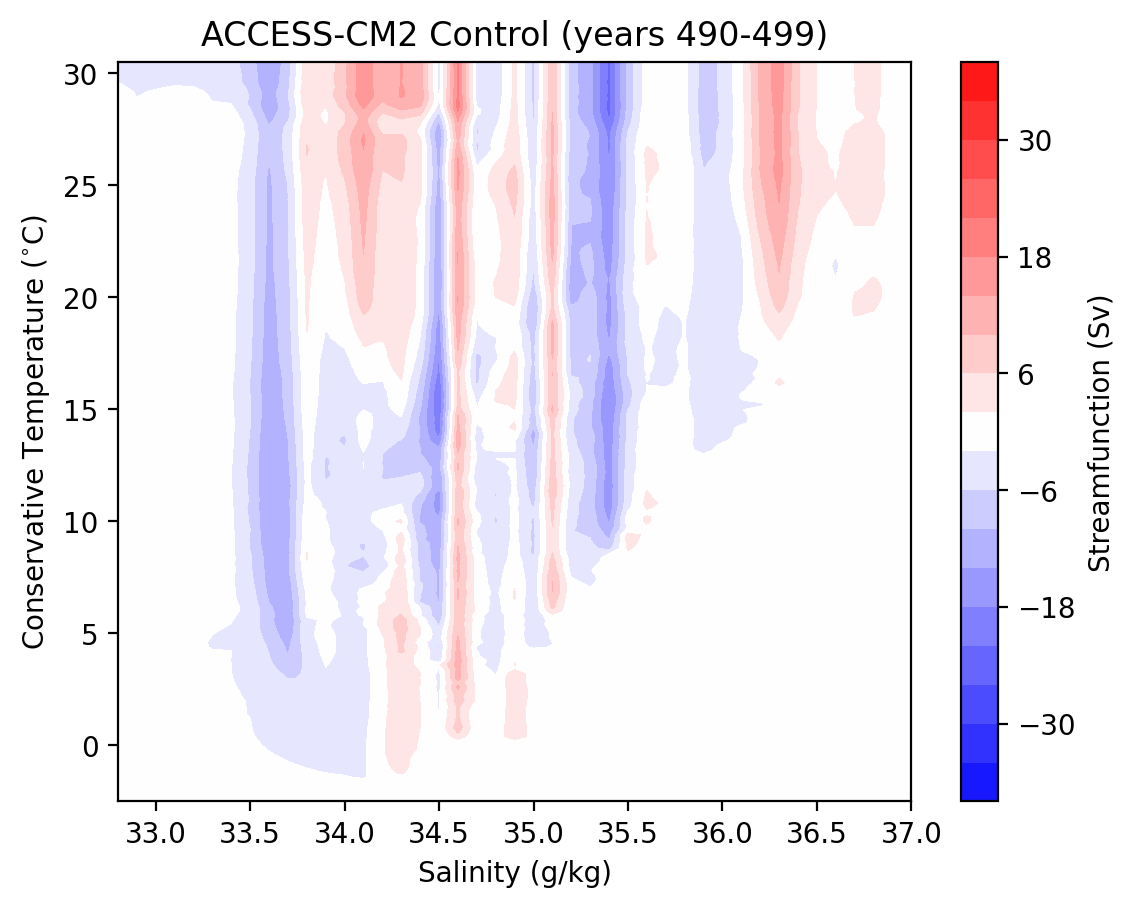

In [22]:
plt.contourf(V1bds,V2bds-273.15,-np.transpose(PSI_ST.mean('time').values),range(-38,39,4),\
             cmap='bwr',vmin=-40,vmax=40)

#seed_points = np.array([[36], [15]])
#dy, dx = np.gradient(np.transpose(PSI_ST.mean('time').values)) # Flow goes down gradient (thus -zi)
#plt.streamplot(Sbds,Tbds,-dy, dx,  color='0.5', density=2)

plt.title('ACCESS-CM2 Control (years 490-499)')
plt.xlabel('Salinity (g/kg)')
plt.ylabel('Conservative Temperature ($^{\circ}$C)')
plt.axis((32.8,37,-2.5,30.5))
cbar = plt.colorbar()
cbar.ax.set_ylabel('Streamfunction (Sv)')
cbar.ax.set_yticks(range(-30,31,12))
plt.savefig("PSITS_ACCESSCM2_490-499.pdf", bbox_inches='tight')


In [17]:
PSI_ST.to_netcdf("PSI_ST_1440_1449.nc")

In [18]:
PSI = xr.open_mfdataset("PSI_ST_1440_1449.nc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [21]:
PSI.PSI_ST.mean('time')

AttributeError: 'Dataset' object has no attribute 'PSI_ST'

In [ ]:
Tbds = np.arange(-5,35,1)
Sbds = np.arange(32,37.5,0.2)
PSI_ST = xr.DataArray(np.zeros((12,len(Sbds),len(Tbds))),\
                      dims=['time', 'salt','temp'],\
                           coords={'time': cc.time,\
                                   'salt': Sbds,\
                                   'temp': Tbds})
for i in range(0,cc.time.shape[0]):
    PSI_ST[i,:,:] = PSI_2VAR(ua[i,:,:,:],va[i,:,:,:],\
                             s[i,:,:,:],s[np.mod(i+1,cc.time.shape[0]),:,:,:],\
                             t[i,:,:,:],t[np.mod(i+1,cc.time.shape[0]),:,:,:],\
                            Volume,Sbds,Tbds)
    if np.mod(i+1,12) == 0:
        print(i+1)
#PSI_ST.mean('time').plot()

12

In [40]:
ua = cc.tx_trans.values/(1e6*rho0)
ua[np.isnan(ua)]=0
va = cc.ty_trans.values/(1e6*rho0)
va[np.isnan(va)]=0

if 'tx_trans_gm' in list(cc.keys()):
    GM = True
    ua_gm = cc.tx_trans_gm.values/(1e6*rho0)
    ua_gm[np.isnan(ua_gm)]=0
    ua_gm[:,1:,:,:] = -ua_gm[:,:-1,:,:]+ua_gm[:,1:,:,:]
    ua = ua+ua_gm
    va_gm = cc.ty_trans_gm.values/(1e6*rho0)
    va_gm[np.isnan(va_gm)]=0
    va_gm[:,1:,:,:] = -va_gm[:,:-1,:,:]+va_gm[:,1:,:,:]
    va = va+va_gm
else:
    GM = False
    
t = cc.temp.values-273.15
s = cc.salt.values
t[:,:,0,:]=t[:,:,-1,::-1]
s[:,:,0,:]=s[:,:,-1,::-1]

Volume = (cc.dht*cc.area_t/(cc.time.dt.days_in_month*day2sec*1e6)).values
Volume[np.isnan(Volume)]=0
Volume[:,:,0,:]=Volume[:,:,-1,::-1]

In [41]:
ua = cc.tx_trans.mean(dim='time').values/(1e6*rho0)
ua[np.isnan(ua)]=0
va = cc.ty_trans.mean(dim='time').values/(1e6*rho0)
va[np.isnan(va)]=0

if 'tx_trans_gm' in list(cc.keys()):
    GM = True
    ua_gm = cc.tx_trans_gm.mean(dim='time').values/(1e6*rho0)
    ua_gm[np.isnan(ua_gm)]=0
    ua_gm[:-1,:,:] = -ua_gm[:-1,:,:]+ua_gm[1:,:,:]
    ua = ua+ua_gm
    va_gm = cc.ty_trans_gm.mean(dim='time').values/(1e6*rho0)
    va_gm[np.isnan(va_gm)]=0
    va_gm[:-1,:,:] = -va_gm[:-1,:,:]+va_gm[1:,:,:]
    va = va+va_gm
else:
    GM = False
    
#if 'ty_trans_submeso' in list(cc.keys()):
#    GM = True
#    ua_sm = cc.tx_trans_submeso.mean(dim='time').values/(1e6*rho0)
#    ua_sm[np.isnan(ua_sm)]=0
#    ua_sm[:-1,:,:] = -ua_sm[:-1,:,:]+ua_sm[1:,:,:]
#    ua = ua+ua_sm
#    va_sm = cc.ty_trans_submeso.mean(dim='time').values/(1e6*rho0)
#    va_sm[np.isnan(va_sm)]=0
#    va_sm[:-1,:,:] = -va_sm[:-1,:,:]+va_sm[1:,:,:]
#    va = va+va_sm
#else:
#    SM = False

Udiv = 0*ua
Udiv[:,:,1:] = ua[:,:,1:] - ua[:,:,0:-1];
Udiv[:,:,0] = ua[:,:,0]-ua[:,:,-1];
Vdiv = 0*ua
Vdiv[:,1:,:] = va[:,1:,:] - va[:,0:-1,:];
Vdiv[:,0,:] = va[:,0,:]-va[:,-1,:];
Wblah = np.cumsum((Udiv+Vdiv)[::-1,:,:],axis=0)[::-1,:,:]
W=0*ua
W[0:-1,:,:]=Wblah[1:,:,:]

In [42]:
t = cc.temp.mean(dim='time').values-273.15
s = cc.salt.mean(dim='time').values
t[:,0,:]=t[:,-1,::-1]
s[:,0,:]=s[:,-1,::-1]

In [43]:
u1t = t
u2t = 0*t
u2t[:,:,:-1]=t[:,:,1:]
u2t[:,:,-1]=t[:,:,0]

u1s = s
u2s = 0*s
u2s[:,:,:-1]=s[:,:,1:]
u2s[:,:,-1]=s[:,:,0]

v1t = t
v2t = 0*t
v2t[:,:-1,:]=t[:,1:,:]
v2t[:,-1,:]=t[:,0,:]

v1s = s
v2s = 0*s
v2s[:,:-1,:]=s[:,1:,:]
v2s[:,-1,:]=s[:,0,:]

w1t = t
w2t = 0*t
w2t[:-1,:,:]=t[1:,:,:]
w2t[-1,:,:]=t[0,:,:]

w1s = s
w2s = 0*s
w2s[:-1,:,:]=s[1:,:,:]
w2s[-1,:,:]=s[0,:,:]

In [44]:
face_flux = np.hstack((ua.flatten(),va.flatten(),W.flatten()))
tup = np.hstack((u1t.flatten(),v1t.flatten(),w1t.flatten()))
sup = np.hstack((u1s.flatten(),v1s.flatten(),w1s.flatten()))
tdn = np.hstack((u2t.flatten(),v2t.flatten(),w2t.flatten()))
sdn = np.hstack((u2s.flatten(),v2s.flatten(),w2s.flatten()))

In [45]:
def TwoVarStream(Tbds,Sbds,tup,sup,tdn,sdn,face_flux):
    PSI_TS = np.zeros((len(Tbds),len(Sbds)))
    for i in range(1,len(Tbds)):
         xup = np.where((tup>Tbds[i]) & (tdn<Tbds[i]))
         xdn = np.where((tup<Tbds[i]) & (tdn>Tbds[i]))
         Ucross = np.concatenate((face_flux[xup],-face_flux[xdn]))
         Scross = np.concatenate((\
             sup[xup]+(Tbds[i]-tup[xup])*(sdn[xup]-sup[xup])/(tdn[xup]-tup[xup]),\
             sup[xdn]+(Tbds[i]-tup[xdn])*(sdn[xdn]-sup[xdn])/(tdn[xdn]-tup[xdn]))) 
         PSI_TS[i,1:] = np.cumsum(np.histogram(Scross,Sbds,weights=Ucross)[0])
    return PSI_TS

In [46]:
Tbds = np.arange(-3,34,1)
Sbds = np.arange(32,37.5,0.2)
PSI_TS = TwoVarStream(Tbds,Sbds,tup,sup,tdn,sdn,face_flux)
PSI_ST = TwoVarStream(Sbds,Tbds,sup,tup,sdn,tdn,face_flux)

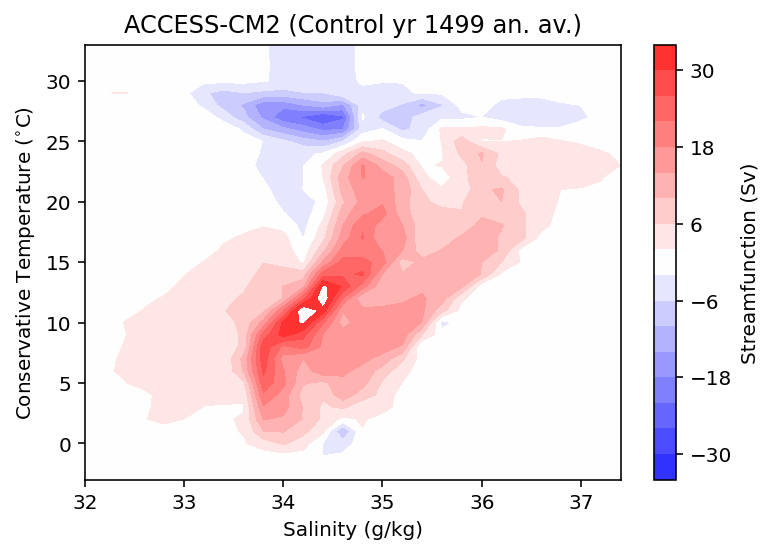

In [47]:
plt.contourf(Sbds,Tbds,np.transpose(PSI_ST),range(-34,35,4),\
             cmap='bwr',vmin=-40,vmax=40)
plt.title('ACCESS-CM2 (Control yr 1499 an. av.)')
plt.xlabel('Salinity (g/kg)')
plt.ylabel('Conservative Temperature ($^{\circ}$C)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Streamfunction (Sv)')
cbar.ax.set_yticks(range(-30,31,12))

In [132]:
PSI_ST2 = PSI_2VAR(sum(ua,0)/12,sum(va,0)/12,sum(s,0)/12,sum(t,0)/12,Sbds,Tbds)

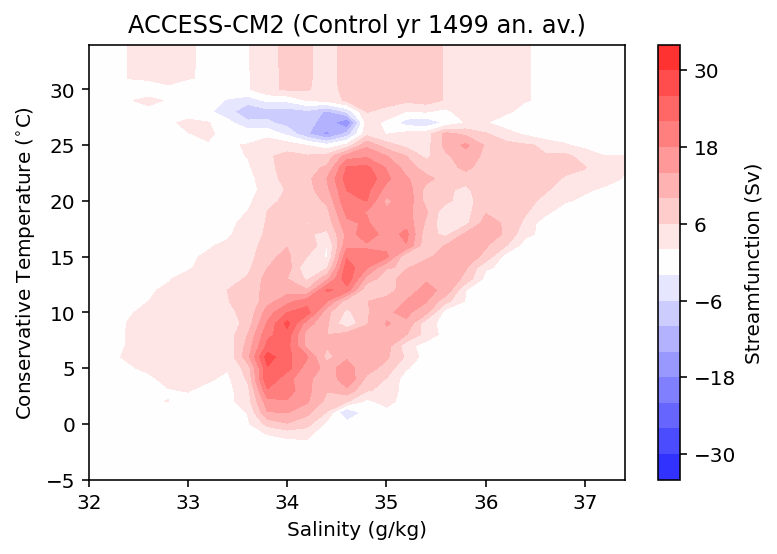

In [133]:
plt.contourf(Sbds,Tbds,np.transpose(PSI_ST2),range(-34,35,4),\
             cmap='bwr',vmin=-40,vmax=40)
plt.title('ACCESS-CM2 (Control yr 1499 an. av.)')
plt.xlabel('Salinity (g/kg)')
plt.ylabel('Conservative Temperature ($^{\circ}$C)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Streamfunction (Sv)')
cbar.ax.set_yticks(range(-30,31,12))